<a href="https://colab.research.google.com/github/lvdamaceno/scraper_anac/blob/master/TCC_Airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acesso ao google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Script para raspagem dos dados


In [8]:
!pip install wget

import requests
import wget
import time
import os
import pandas as pd
from bs4 import BeautifulSoup

project_directory = '/content/drive/My Drive/tcc_puc_dados_anac/'

In [0]:
def request_page(url):
    # captura todas as tags a href da pagina inicial
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    tag_pre = soup.find_all('pre')
    tag_a = tag_pre[0].find_all('a')
    return tag_a

def get_links(data, url):
    # cria uma lista apenas com os links tratados
    data_links = []
    for item in range(len(data)):
        text = data[item].get_text()
        data_links.append(url + text)
    return data_links


def get_files(data, folder, link):
    for item in range(len(data)):
        text = data[item].get_text()
        start_timer = time.perf_counter()
        wget.download(link + '/' + text, folder)
        end_timer = time.perf_counter()
        print(f"Download de {text} em {end_timer - start_timer:0.4f} segundos")

In [0]:
# Executar apenas se os arquivos não estiverem baixados

url_anac = 'https://sas.anac.gov.br/sas/vraarquivos/'
data_anac = request_page(url_anac)
data_links = get_links(data_anac, url_anac)
directory = "/content/drive/My Drive/tcc_puc_dados_anac/files"
for link in data_links[1:-1]:
    data = request_page(link)[1:]
    get_files(data, directory, link)

# Concatenando arquivos por ano

In [0]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

In [0]:
def files_list(path):
    files_names = [file_name for file_name in listdir(path) if isfile(join(path, file_name))]
    files_names.sort()
    return files_names


def year_list(path):
    files_names = [file_name for file_name in listdir(path) if isfile(join(path, file_name))]
    all_names = [item[4:8] for item in files_names]
    filtered_years = list(set(all_names))
    filtered_years.sort()
    return filtered_years

In [0]:
files_dir = '/content/drive/My Drive/tcc_puc_dados_anac/files'
cancat_by_year_dir = '/content/drive/My Drive/tcc_puc_dados_anac/concat_by_year'

files = files_list(files_dir)
years = year_list(files_dir)

for year in years:
    concat_year_df = pd.DataFrame()
    for csv_file in files:
        if csv_file[4:8] == year:
            tempDf = pd.read_csv(f'{files_dir}/{csv_file}'
            , encoding='ISO-8859-1', )
            concat_year_df = pd.concat([concat_year_df, tempDf], ignore_index=True)
            print(f'Concat de {csv_file} feito')
    concat_year_df.to_csv(f'{cancat_by_year_dir}/{year}.csv')
    print(f'Dataset {year}.csv salvo com sucesso.')

In [0]:
# head de um arquivo com dados mensais
data = pd.read_csv("/content/drive/My Drive/tcc_puc_dados_anac/files/VRA_20001.csv", encoding='ISO-8859-1') 
data.head()

In [0]:
# head de um arquivo com dados anuais
data = pd.read_csv(f'{project_directory}concat_by_year/2001.csv') 
data.head(10)

# Principais Aeroportos do Brasil

In [0]:
df_principais_aeroportos = pd.read_csv(f'{project_directory}principais_aeroportos_brasil.csv')
df_principais_aeroportos

In [0]:
icao_principais = df_principais_aeroportos['ICAO']

# Principais motivos para cancelamentos


[IAC 1504](https://www.anac.gov.br/assuntos/legislacao/legislacao-1/iac-e-is/iac/iac-1504/@@display-file/arquivo_norma/IAC1504.pdf)

In [0]:
def top_10_cancelamentos(ano):
    # Justificativas para cancelamento
    df_iac_1504 = pd.read_csv(f'{project_directory}IAC_1504.csv',
                                index_col=0, names=['Código Justificativa', 'Justificativa'])
    df_voos = pd.read_csv(f'{project_directory}concat_by_year/{ano}.csv',
                                    low_memory=False, index_col=None).dropna()
    # Filtra o data frame com a lista de pricipais aeroportos                                
    df_voos['ICAO Aeródromo Origem'].isin(icao_principais)
    df_voos_icaos = df_voos[df_voos['ICAO Aeródromo Origem'].isin(icao_principais)]
    df_voos_icaos['Código Justificativa']
    # Cria um Top 10 com os pricipais motivos
    result = pd.merge(df_voos_icaos, df_iac_1504, on='Código Justificativa')
    return result['Justificativa'].value_counts().head(10)

In [0]:
def plot_cancelamentos(ano):
    top_10 = top_10_cancelamentos(ano)
    top_10_plot = top_10.plot(kind='barh', figsize=(6, 3), color='#86bf91', zorder=2, width=0.85)
    # Despine
    top_10_plot.spines['right'].set_visible(False)
    top_10_plot.spines['top'].set_visible(False)
    top_10_plot.spines['left'].set_visible(False)
    top_10_plot.spines['bottom'].set_visible(False)
    # Switch off ticks
    top_10_plot.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    # Draw vertical axis lines
    vals = top_10_plot.get_xticks()
    for tick in vals:
        top_10_plot.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    # Set x-axis label
    top_10_plot.set_xlabel("Quantidade de Cancelamentos)", labelpad=20, weight='bold', size=10)
    # Set y-axis label
    top_10_plot.set_ylabel("Motivo do Cancelamento", labelpad=20, weight='bold', size=10)
    top_10_plot.set_title(f"Ano {ano}",  weight='bold', size=10)

## Gráficos

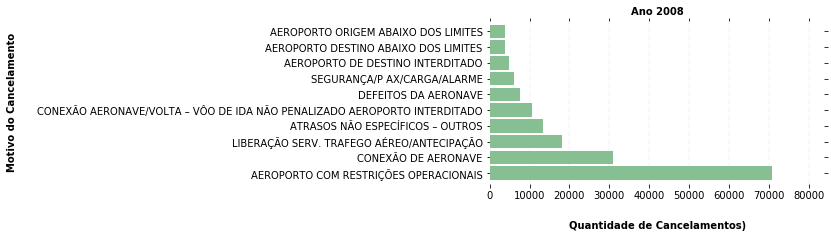

In [15]:
plot_cancelamentos(2008)

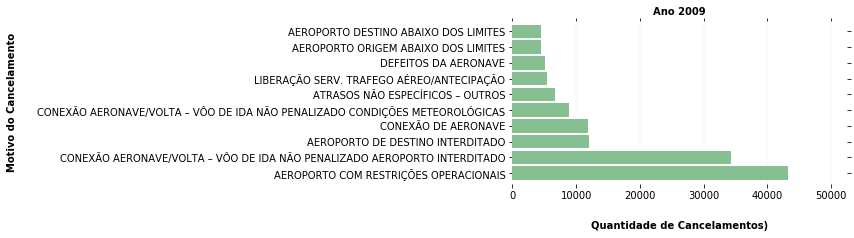

In [16]:
plot_cancelamentos(2009)

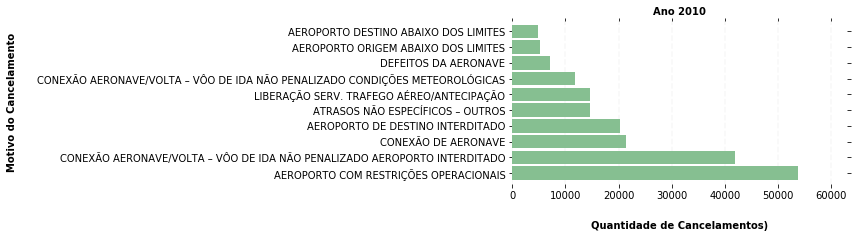

In [17]:
plot_cancelamentos(2010)

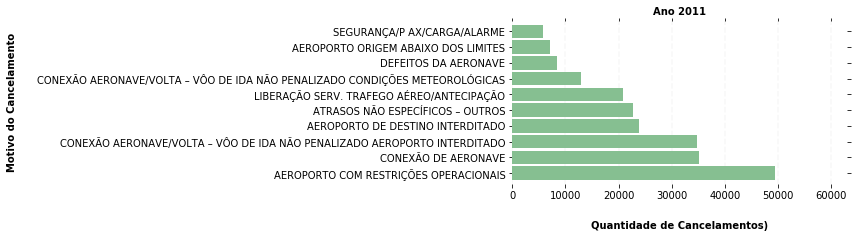

In [18]:
plot_cancelamentos(2011)

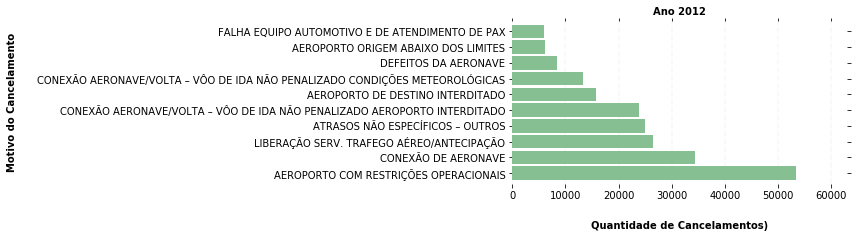

In [19]:
plot_cancelamentos(2012)

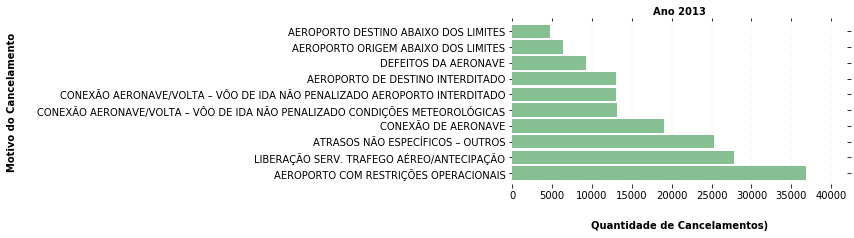

In [20]:
plot_cancelamentos(2013)

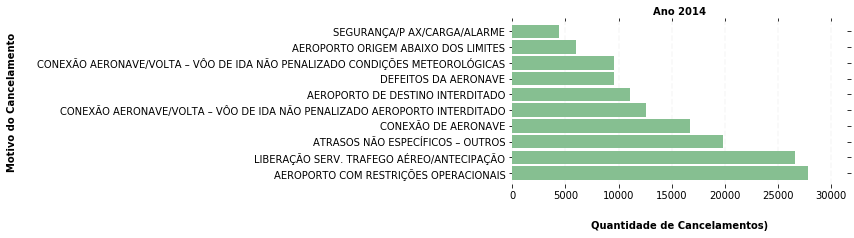

In [21]:
plot_cancelamentos(2014)

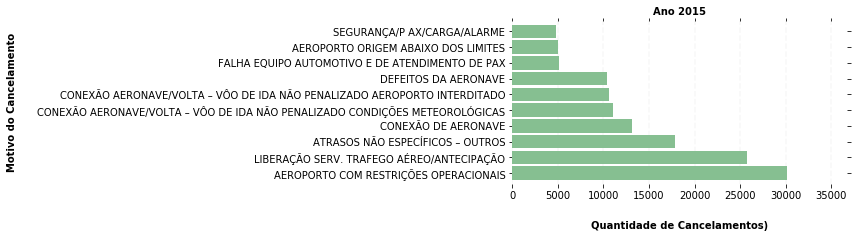

In [22]:
plot_cancelamentos(2015)

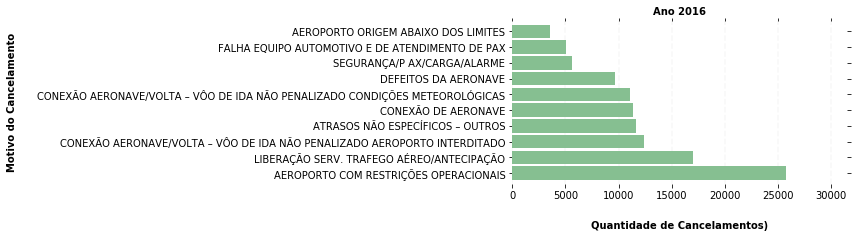

In [23]:
plot_cancelamentos(2016)

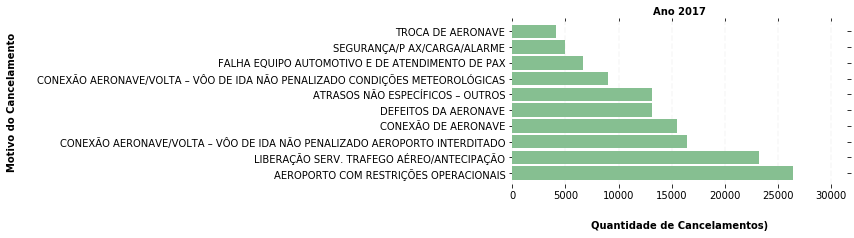

In [24]:
plot_cancelamentos(2017)

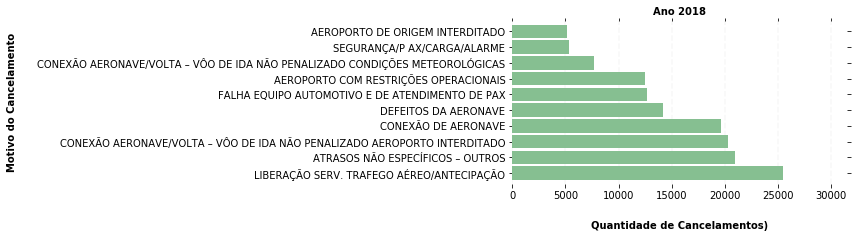

In [25]:
plot_cancelamentos(2018)

# Tempo médio de atraso

In [0]:
#tmp = []

#for ano in ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']:
#    df = pd.read_csv(f'{project_directory}concat_by_year/{ano}.csv', index_col=None, header=0)
#    tmp.append(df)

#pd_gru = pd.concat(tmp, axis=0, ignore_index=True) 

#df_2019 = pd.read_csv(f'{project_directory}concat_by_year/2019.csv', index_col=None, header=0)

# Carrega voos
df_voos = pd.read_csv(f'{project_directory}concat_by_year/2018.csv', low_memory=False, index_col=0)

# Remove qualquer voo que não tenha sido realizado
indexInvalidos = df_voos[df_voos['Situação Voo'] != 'REALIZADO'].index
df_voos.drop(indexInvalidos , inplace=True)


# Remove registros com datas de partidas previstas invalidas
indexInvalidos = df_voos[df_voos['Partida Prevista'].str.len() != 16].index
df_voos.drop(indexInvalidos , inplace=True)

# Remove registros com datas de partidas real invalidas
indexInvalidos = df_voos[df_voos['Partida Real'].str.len() != 16].index
df_voos.drop(indexInvalidos , inplace=True)


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
# Converte de string para datetime 
pd.to_datetime(df_voos['Partida Prevista'], format = "%d/%m/%Y %H:%M")

# Converte de string para datetime
pd.to_datetime(df_voos['Partida Real'], format = "%d/%m/%Y %H:%M")

# Calcula a diferença entre a partida prevista e a partida real
df_voos['Diferenca de Partida'] = (df_voos['Partida Real DT'] - df_voos['Partida Prevista DT']).fillna(0).dt.total_seconds()

#print(df_voos['Diferenca de Partida'])

# Remove os voos em que a decolagem ocorreu antes ou na hora prevista
indexAdiantadoOuNaHora = df_voos[df_voos['Diferenca de Partida'] <= 0].index
df_voos = df_voos.drop(indexAdiantadoOuNaHora)



# Remove voos em que a data as horas de atraso foi maior ou menor que 0 horas, voos adiantados não interessam aqui
#indexInvalidos = df_voos[(df_voos['Diferenca de Partida'] < 0) & df_voos['Diferenca de Partida'] > 24].index
#df_voos.drop(indexInvalidos , inplace=True)

# Converte para horas a diferença
df_voos['Diferenca de Partida 1'] = df_voos['Diferenca de Partida'].div(60).div(60).apply(np.ceil).astype(int)

df_voos['Diferenca de Partida 1']

#df_voos['Diferenca de Partida 1'].plot.kde()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  import sys


7          1
17         1
29         1
43         1
55         1
          ..
1035119    1
1035129    1
1035131    2
1035138    1
1035161    1
Name: Diferenca de Partida 1, Length: 293285, dtype: int64

O Grafico abaixo mostra qual a porcentagem dos voos que partiram atrasados, **91 % atrasou entre 1 e 2 horas**.

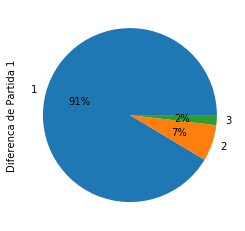

In [0]:
values = df_voos['Diferenca de Partida 1'].value_counts().head(3)
#print(values)
values.plot.pie(autopct='%1.0f%%')

In [0]:
#